In [1]:
"""
SPOT: Shared Parameter Optimization Tool
"""

###Imports###
import scipy
import numpy as np
from numpy import random
import array
from numba import jit
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.optimize import basinhopping
import multiprocessing
from multiprocessing import Pool, cpu_count
import itertools
import pandas as pd
import math
from deap import base
from deap import creator
from deap import tools
import warnings
warnings.filterwarnings("ignore")

In [2]:
###Function definitions###

#Turn Lower and Upper bounds vectors into a packed bounds vector, using a sharing genome
def genomeBounds(bndsmin, bndsmax, genome, depth):
    size = len(genome)
    for i in range(0,size*(depth-1)):
        idex = i%size
        if genome[idex]==True:
            bndsmin = np.append(bndsmin, bndsmin[idex])
            bndsmax = np.append(bndsmax, bndsmax[idex])

    return np.stack((bndsmin,bndsmax))


#Unpack a short vector and a shared genome into full length parameter vectors
def convertVectors(par, G, C):
    """
    example:
    par = [1,2,3,4,5,6,10,30,40,60,100,300,400,600]
    G = [1,0,1,1,0,1]
    C = 2
    res = [[1, 2, 3, 4, 5, 6],[10, 2, 30, 40, 5, 60],[100, 2, 300, 400, 5, 600]]
    """
    
    res = np.empty((C, len(G)))  # result
    r = np.arange(0,len(G)*C)    #How many parameters need to be assigned

    if len(par) > (C-1)*np.sum(G)+len(G): #Predict par length and check for par>needed
        raise ValueError("More parameters have been given than needed")
    else:
        
        for i in r:
            c, p = np.divmod(i,len(G)) #equal to x//y, x%y
            cur=len(G[0:p])
            tot=np.sum(G[0:p])
            res[c,p] = par[p+G[p]*c*int(len(G)-cur+tot)]

    return res

#Picks a uniformly random parameter vector, p, in half interval range of a vector of [low,high) bounds.
def drawP(bounds):
    rng = np.random.default_rng()
    drawnP=rng.uniform(bounds[0,:],bounds[1,:])
    return drawnP

#Takes in a list of strings, pointed to csv's with data, and returns multidimensional arrays of data
def stacker(datcol, timecol, target):
    #Needed for stacking data arrays in the loop below
    firstIteration = True
    
    for i in range(0,len(target)):
        #Read in data
        data = np.genfromtxt(target[i], skip_header=1,delimiter=',',usecols=datcol)

        #Read in time points
        tData = np.genfromtxt(target[i], skip_header=1,delimiter=',',usecols=timecol)
                
        if firstIteration:
            #Prepare the data, time, and cov arrays to be stacked depth-wise
            dataStack = np.expand_dims(data,axis=-1)
            tStack = np.expand_dims(tData,axis=-1)
            firstIteration = False

        else:
            #Stack the data, time, and cov arrays
            dataStack = np.concatenate((dataStack,np.expand_dims(data,axis=-1)),-1)
            tStack = np.concatenate((tStack,np.expand_dims(tData,axis=-1)),-1)
    return dataStack, tStack

def safe_log(points,base):
    points[points == 0] = 1e-4
    return math.log(points,base)

#Define an objective function wrapper for SSE
def objective_function(p, fxn, u, tPred, data, dataIndex, tData, genome, cohorts):

    #Split the combined parameter vector
    pUnpacked = convertVectors(p, genome, cohorts)

    #Initialize the error
    error = 0
    
    for l in range(0,len(pUnpacked)):
        pSplit = pUnpacked[l]
        
        #Run the ODE system to find predicted ODE solution
        argTup = np.append(pSplit,u[l][2]) #Add MCP1@t=0. Shouldn't need this for most datasets
        sol = odeint(fxn,u[l],tPred[:,l],args=(argTup,)) #Integrate the ODEs
        
        #Check for infs and NaNs in the ODE soution
        if (np.all(np.isfinite(sol))==False):
            #print("Objective Function caught an Inf or NaN")
            error = float("inf")
        else:
            
            #Calculate SSE based on states which are a) given in data and b) present in ODE solution
            #Condition b is always satisfied by any state which satisfies a, 
            #so this check should only catch errors
            for j in np.intersect1d(np.arange(0,sol.shape[-1]),dataIndex):
                
                #Normalize the ODE predictions
                solNorm = sol[:,j]
                
                #Select only predicted points whose time matches data's time 
                pred = solNorm[np.searchsorted(tPred[:,l],tData[:,l], side='right')-1]
                #pred[pred == 0] = 1e-4 #remove zeros for logs later
                
                #User provided cost function goes here
                #For EEA's MCP model currently, any SSE-like method should work
                #Calculate the SSE for the indicated data set/prediction
                A = (pred - data[:,j,l])**2
                B = 2*data[:,j,l]
                error += np.nansum(A/B)
                #error += np.nansum(np.true_divide(A, B, where=(B!=0)))
    
    return error

#Custom step-function for bounded basin hopping
class RandomDisplacementBounds(object):
    def __init__(self, xmin, xmax, stepsize=0.5):
        self.xmin = xmin
        self.xmax = xmax
        self.stepsize = stepsize

    def __call__(self, x):
            
        range_step = self.xmax - self.xmin
        min_step = np.maximum(self.xmin - x, -self.stepsize * range_step)
        max_step = np.minimum(self.xmax - x, self.stepsize * range_step)

        RandomStep = np.random.uniform(low=min_step, high=max_step, size=x.shape)
        
        xnew = x + RandomStep

        return xnew
    
#Function to calculate BIC from a genome
def evaluate(individual,log_energy=False):
        
    #Tile the bounds according to the genome
    bnds = genomeBounds(bndsmin, bndsmax, individual, tPred.shape[-1])
    
    #Calculate how many cohorts are present
    cohorts = tPred.shape[-1]
    
    #Create an initial parameter guess, randomly (cold start)
    p0 = drawP(bnds)
    
    #Arguments for objective function
    argTuple = tuple((fxn, u, tPred, dataStack, dataIndex, tStack, individual, cohorts))
    
    #Arguments for non-stochastic gradient descent portion of basin hopping
    kwargs = {'method':lclMin,'args':(argTuple),'bounds':scipy.optimize.Bounds(bnds[0,:], bnds[1,:]),
              'tol':lclTol, 'options':{'maxiter':lclIter, 'disp':False, 'ftol':lclTol}}
    
    #Define the custom bounded step function for Basin Hopping. Must be defined after "bnds" are set
    bounded_step = RandomDisplacementBounds(np.array([b for b in bnds[0,:]]),
                                                 np.array([b for b in bnds[1,:]]),
                                                 bhStep)
    #Define the energy-logging custom Metropolis stepping function. Use with caution - will run slowly and create many log files
    metropolis_log = Metropolis_Logger(Temp, random_gen=np.random.default_rng())
    if log_energy == True:
        accept_test = metropolis_log
    else:
        accept_test = None
    
    #Run the basin hopping
    result = basinhopping(objective_function, p0, niter = bhIter, 
                          minimizer_kwargs = kwargs, disp = bhDisp,
                          take_step = bounded_step, T = Temp, 
                          stepsize = bhStep, interval = bhInt, 
                          niter_success = bhIterExit, accept_test = accept_test)

    #Calculate the Bayesian Information Criterion
    DOF = len(individual) + np.sum(individual)

    BIC = DOF * math.log(math.prod(dataStack.shape)) + 2 * result.fun #BIC
    AIC = 2*DOF + 2*result.fun
    
    return AIC, BIC, result.x, result.fun

In [3]:
#Custom Metropolis accept test class to log all BH-step minima
#Original code from SciPy

class Metropolis_Logger:
    """Metropolis acceptance criterion.
    Parameters
    ----------
    T : float
        The "temperature" parameter for the accept or reject criterion.
    random_gen : {None, int, `numpy.random.Generator`,
                  `numpy.random.RandomState`}, optional
        If `seed` is None (or `np.random`), the `numpy.random.RandomState`
        singleton is used.
        If `seed` is an int, a new ``RandomState`` instance is used,
        seeded with `seed`.
        If `seed` is already a ``Generator`` or ``RandomState`` instance then
        that instance is used.
        Random number generator used for acceptance test.
    """

    def __init__(self, T, random_gen=None):
        # Avoid ZeroDivisionError since "MBH can be regarded as a special case
        # of the BH framework with the Metropolis criterion, where temperature
        # T = 0." (Reject all steps that increase energy.)
        self.beta = 1.0 / T if T != 0 else float('inf')
        self.random_gen = check_random_state(random_gen)

    def accept_reject(self, energy_new, energy_old):
        """
        If new energy is lower than old, it will always be accepted.
        If new is higher than old, there is a chance it will be accepted,
        less likely for larger differences.
        """
        with np.errstate(invalid='ignore'):
            # The energy values being fed to Metropolis are 1-length arrays, and if
            # they are equal, their difference is 0, which gets multiplied by beta,
            # which is inf, and array([0]) * float('inf') causes
            #
            # RuntimeWarning: invalid value encountered in multiply
            #
            # Ignore this warning so so when the algorithm is on a flat plane, it always
            # accepts the step, to try to move off the plane.
            prod = -(energy_new - energy_old) * self.beta
            w = math.exp(min(0, prod))

        rand = self.random_gen.uniform() #Pull a random number to compare to
        test_result = (w >= rand) #Should the step be accepted?
        
        if test_result == True:
            #Here's where the data should be written out
            #Include energy_new and some way of retaining step order
            #Maybe append to a file? Slow but easy - just needs step number and which genome
            test_array = (23.5, 0)
            fname = ('./logs/'+ str(energy_new) + '.csv')
            np.savetxt(fname,test_array) #Currently, just overwrite the same file to see worst-case performance impact
            
            #Issues
            #np.savetxt won't create subdirectories
            #energy_new is 0D, np.savetxt doesn't like this
            #Parameters aren't saved
            #Can't open the same file from multiple processes
            #Don't have a way to identify which genome we're on to log appropriately 
            #Seems to record up to 5x more often than bhiterations would suggest...
            #1kb per BH iteration
            #Time impact untested
            
        return test_result

    def __call__(self, **kwargs):
        """
        f_new and f_old are mandatory in kwargs
        """
            
        return bool(self.accept_reject(kwargs["f_new"],kwargs["f_old"]))
    
    
from scipy._lib._util import check_random_state
import numbers

In [4]:
###User Input starts here###

#Create the ODE system
@jit(nopython=True)
def f4(u, t, p):
    k, big_k, r_ifn_v, d_v, p_v_ifn, d_ifn, k1, k2, d_mcp1, n1, mcp10 = p
    v, ifn, mcp1 = u
    dy = (k*v*(1-v/big_k) - r_ifn_v*(ifn)*v - d_v*v,
    p_v_ifn*v - d_ifn*(ifn),
    (k1*(ifn)**n1)/(k2+(ifn)**n1)-(mcp1-mcp10)*d_mcp1)
    return dy

#Model
@jit(nopython=True)
def f1(u, t, p):
    k, big_k, r_ifn_v, d_v, p_v_ifn, d_ifn, k1, k2, d_mcp1, n1, d_v_mcp1, mcp10 = p
    v, ifn, mcp1 = u
    dy = (k*v*(1-v/big_k) - r_ifn_v*(ifn)*v - d_v*v - d_v_mcp1*v*(mcp1-mcp10),
    p_v_ifn*v - d_ifn*(ifn),
    (k1*(ifn)**n1)/(k2+(ifn)**n1)-(mcp1-mcp10)*d_mcp1)
    return dy

#Create the ODE system
@jit(nopython=True)
def f2(u, t, p):
    k, big_k, r_ifn_v, d_v, p_v_ifn, d_ifn, k1, k2, d_mcp1, n1, p_ifn_mcp1, mcp10 = p
    v, ifn, mcp1 = u
    dy = (k*v*(1-v/big_k) - r_ifn_v*(ifn)*v - d_v*v,
    p_v_ifn*v - d_ifn*(ifn) + p_ifn_mcp1*(mcp1-mcp10),
    (k1*(ifn)**n1)/(k2+(ifn)**n1)-(mcp1-mcp10)*d_mcp1)
    return dy

#Create the ODE system
@jit(nopython=True)
def f3(u, t, p):
    k, big_k, r_ifn_v, d_v, p_v_ifn, d_ifn, k1, k2, d_mcp1, n1, d_v_mcp1, p_ifn_mcp1, mcp10 = p
    v, ifn, mcp1 = u
    dy = (k*v*(1-v/big_k) - r_ifn_v*(ifn)*v - d_v*v- d_v_mcp1*v*(mcp1-mcp10),
    p_v_ifn*v - d_ifn*(ifn) + p_ifn_mcp1*(mcp1-mcp10),
    (k1*(ifn)**n1)/(k2+(ifn)**n1)-(mcp1-mcp10)*d_mcp1)
    return dy
        
#Where is the data located? A list of string file locations
target = ('./Data/Real Data/data_h1n1_logged.csv',
          './Data/Real Data/data_h5n1_logged.csv'
         )

#Which column contains time? Same for all data sets 
timecol = 1

#Which column(s) contain data? Same for all data sets
datcol = (2,3,4)

#Get the multidimensional stacked data
#Shouldn't require any user input/modification
dataStack, tStack = stacker(datcol, timecol, target)
    
#What is the function handle that contains the ODE system? jit encouraged. Same system for all strains
fxn = f4

#Lower and Upper bounds vectors for each parameter in p

#logged
bndsmin = np.array((0, 1e-3, 0, 0, 0, 0, 0, 1e-3, 0, 0))
bndsmax = np.array((10.0, 50.0, 1.0, 5.0, 5.0, 5.0, 1e5, 1e5, 10.0, 10.0))

#What temperature should the basin hopping algorithm operate with? ~= objective fxn difference between minima
#Default 1.0
Temp = 50

#Known initial conditions. Use [[x1,y1,z1],...,[xn,yn,zn]] for different ICs
u = [[6.819798, 0, 6.89763],[7.10321, 0, 6.907868]] #logged

#Known time span to solve in. Fed directly to the solver! Increase number of points for stiff/unstable systems
t = np.linspace(0,6,100) 

#Ensure that every data point's time is exactly within the predicted tspan
#Shouldn't require any user input/modification
tPred = np.sort(np.unique(np.concatenate((t,tStack[:,0])),0))

#If only 1 data set/model, create a singleton axis of the ODE time points
#Otherwise, repeat the time points along a new axis. One per strain.
#Shouldn't require any user input/modification
if (dataStack.shape[-1] == 1):
    tPred = np.expand_dims(tPred,-1)
else:
    tPred = np.repeat(np.expand_dims(tPred,-1),dataStack.shape[-1],axis=-1)

#Which states should be used for SSE calculations? Applies to all data sets! 
dataIndex = np.array((0,1,2))

#What method should be used for the local minimizer portion of basinhopping?
#Valid, bounded methods are: TNC, Powell, trust-constr, SLSQP, Nelder-Mead, and L-BFGS-B
#Defaults to SLSQP, which is typically the fastest method
lclMin = 'SLSQP'
    
#Tolerance parameter for gradient descent portion of Basin Hopping. Default 1e-3
lclTol = 1e-3
    
#Max iterations for local solver. 100-250 typically plenty for moderate ODE systems
lclIter = 100

#Maximum number of basinhopping iterations. Default 100
bhIter = 10

#Should basinhopping print progress messages to the console? Defaults to True
bhDisp = False

#Initial step size of basinhopping algorithm. Defaults to 0.5 (50%)
#Taken as a proportion of each parameter's range (upper bound - lower bound)
bhStep = 0.5

#basinhopping will attempt to update Step Size per n iterations to maintain 50% acceptance. Default 10
bhInt = 10

#If no new global minimum is found in n basinhopping iterations, exit. Default 50
bhIterExit = 50

In [60]:
genome = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
AIC, BIC, par, e = evaluate(genome)
bh_time = %timeit -o evaluate(genome,log_energy=False)

#log_energy True: Untested, method not yet implemented
#Log_energy False: 15.1s ± 2.8 s per loop (mean ± std. dev. of 7 runs, 1 loop each)

11.4 s ± 2.22 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [61]:
print("AIC: "+str(AIC))
print("BIC: "+str(BIC))
print("e: "+str(e))
print("par: "+str(par))

AIC: 46.86510947516329
BIC: 93.99928600895511
e: 3.4325547375816425
par: [3.30377396e+00 4.34144142e+01 1.11925991e-01 1.89037035e+00
 6.96635178e-01 7.93751408e-01 2.29940810e+04 2.26709865e+04
 7.52963167e+00 1.43764128e+00 1.86781151e+00 1.82728917e+01
 5.79151153e-02 9.02649583e-18 2.92138652e+00 3.12147772e+00
 3.65992127e+04 8.32900482e+04 6.69902254e+00 1.89916705e+00]


Text(0, 0.5, 'Log2 PFU/g')

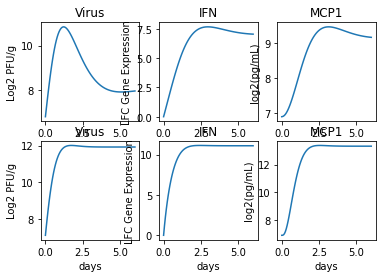

In [49]:
#Initial conditions
import matplotlib.pyplot as plt

pUnpack = convertVectors(par, genome, 2)
par_h1n1 = pUnpack[0]
par_h5n1 = pUnpack[1]
#Parameter values
mcp10 = 6.89763 #logged, h1n1
mcp10 = 6.907868 #logged, h5n1

#Prepare arguments for solver
argTup_h1n1 = np.append(par_h1n1, mcp10)
argTup_h5n1 = np.append(par_h5n1, mcp10)

u0_h1n1=[6.819798, 0, 6.89763] #h1n1
u0_h5n1=[7.10321, 0, 6.907868] #h5n1

#Solve the model
from scipy.integrate import odeint
sol_h1n1 = odeint(fxn,u0_h1n1,t,args=(argTup_h1n1,),mxstep=500000)
sol_h5n1 = odeint(fxn,u0_h5n1,t,args=(argTup_h5n1,),mxstep=500000)

#plot
fig, axes = plt.subplots(2, 3) 

for i in range(0,3):

    #Get the species from the ODE solution
    Pred_h1n1 = sol_h1n1[:,i]
    Pred_h5n1 = sol_h5n1[:,i]
    
    #Plot predicted values
    axes[0,i].plot(t,Pred_h1n1)
    axes[1,i].plot(t,Pred_h5n1)   
    
axes[0,1].set_title('IFN')
axes[0,1].set_xlabel('days')
axes[0,1].set_ylabel('LFC Gene Expression')
axes[1,1].set_title('IFN')
axes[1,1].set_xlabel('days')
axes[1,1].set_ylabel('LFC Gene Expression')

axes[0,2].set_title('MCP1')
axes[0,2].set_ylabel('log2(pg/mL)')
axes[0,2].set_xlabel('days')
axes[1,2].set_title('MCP1')
axes[1,2].set_ylabel('log2(pg/mL)')
axes[1,2].set_xlabel('days')

axes[0,0].set_title('Virus')
axes[0,0].set_xlabel('days')
axes[0,0].set_ylabel('Log2 PFU/g')
axes[1,0].set_title('Virus')
axes[1,0].set_xlabel('days')
axes[1,0].set_ylabel('Log2 PFU/g')